# ** Описание **

In [ ]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import mmh3
import xgboost as xgb
import numpy as np

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = mmh3.hash(word.encode("utf-8"))
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
def calc_features(url, html_data):
    words = list(html2word(html_data))
    compression_level = len(zlib.compress(html_data)) / len(html_data) 

    return [0, compression_level]

In [11]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features', 'words'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features, list(html2word(html_data)))            
                
        trace(i, 1)

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [12]:
TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab.csv.gz'
# TRAIN_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

23:54:48 INFO:Complete items 00000
23:55:30 INFO:Complete items 01000
23:56:05 INFO:Complete items 02000
23:56:42 INFO:Complete items 03000
23:57:17 INFO:Complete items 04000
23:57:56 INFO:Complete items 05000
23:58:32 INFO:Complete items 06000
23:59:11 INFO:Complete items 07000
23:59:12 INFO:Complete items 07043


In [25]:
class Classifier:
    
    def __init__(self):
        self.p_h = {}
        self.p_s = {}
        self.h = 0
        self.header_weight = 1

    def predict(self, doc):
        import math
        spam_n = 1
        ham_n = 1
        some_sum = 0

        for word in doc.words:
            if word not in self.p_s or word not in self.p_h:
                continue
            some_sum += math.log(self.p_s[word] / self.p_h[word])

        return some_sum                 
    
    def predict_all(self, docs):
        res = []
        other = []
        for doc_num, doc in enumerate(docs):
            doc.features[0] = self.predict(doc)
            res.append(doc.features)
            other.append((doc.doc_id, doc.is_spam, doc.url))
        trace(len(res))
            
        dtrain = xgb.DMatrix(np.array(res))
        prediction = self.bst.predict(dtrain) 
        trace(len(prediction))
        
        i = 0
        result = []
        for (idd, iss, url) in other:
            result.append( (idd, iss, url, prediction[i]) )
            i += 1
            trace(doc_num)
        trace(len(res))
        return result
    
    def train(self, docs):     
        ham_amount = 0
        spam_amount = 0
        in_ham = {}
        in_spam = {}
        
        for doc_num, doc in enumerate(docs):
            if doc.is_spam:
                spam_amount += len(doc.words)
                for word in doc.words:
                    in_spam[word] = in_spam.get(word, 0) + 1
            else:
                ham_amount += len(doc.words)
                for word in doc.words:
                    in_ham[word] = in_ham.get(word, 0) + 1

        for k, v in in_ham.items():
            self.p_h[k] = v / ham_amount

        for k, v in in_spam.items():
            self.p_s[k] = v / spam_amount
        
        features = []
        labels = []
        
        for doc_num, doc in enumerate(docs):
            doc.features[0] = self.predict(doc)
            features.append(doc.features)
            labels.append(doc.is_spam)
            trace(doc_num)
            
        features = np.array(features)
        labels = np.array(labels)
        param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic', 'nthread':4}
        dtrain = xgb.DMatrix(features, label=labels)
        
        watchlist  = [(dtrain,'train')]
        num_round = 50
        self.bst = xgb.train(param, dtrain, num_round, watchlist)
        
        trace(doc_num, 1)

In [26]:
classifier = Classifier()
classifier.train(train_docs)

00:39:19 INFO:Complete items 00000
00:39:21 INFO:Complete items 01000
00:39:22 INFO:Complete items 02000
00:39:23 INFO:Complete items 03000
00:39:25 INFO:Complete items 04000
00:39:27 INFO:Complete items 05000
00:39:28 INFO:Complete items 06000
00:39:30 INFO:Complete items 07000


[0]	train-error:0.035775
[1]	train-error:0.036627
[2]	train-error:0.036627
[3]	train-error:0.034072
[4]	train-error:0.036201
[5]	train-error:0.035349
[6]	train-error:0.034497
[7]	train-error:0.034497
[8]	train-error:0.032794
[9]	train-error:0.031374
[10]	train-error:0.031374
[11]	train-error:0.031374
[12]	train-error:0.031374
[13]	train-error:0.031374
[14]	train-error:0.030806
[15]	train-error:0.030239
[16]	train-error:0.030097
[17]	train-error:0.030097
[18]	train-error:0.030097
[19]	train-error:0.030097
[20]	train-error:0.029671
[21]	train-error:0.029245
[22]	train-error:0.029245
[23]	train-error:0.029245
[24]	train-error:0.029245
[25]	train-error:0.029245
[26]	train-error:0.029387
[27]	train-error:0.029387
[28]	train-error:0.029103
[29]	train-error:0.028535
[30]	train-error:0.028251
[31]	train-error:0.028677
[32]	train-error:0.028535
[33]	train-error:0.028535
[34]	train-error:0.028535
[35]	train-error:0.028393
[36]	train-error:0.027825
[37]	train-error:0.027825
[38]	train-error:0.027

00:39:31 INFO:Complete items 07043


threshold 0
	class_prec 0.583333333333, class_recall 1.0, class_F1 0.736842105263
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.368421052632
threshold 0.001
	class_prec 0.596978061892, class_recall 1.0, class_F1 0.747634643377
	not_class_prec 1.0, not_class_recall 0.0548551959114, not_class_F1 0.104005167959
		MacroF1Mesure 0.425819905668
threshold 0.002
	class_prec 0.628191408042, class_recall 1.0, class_F1 0.771643192488
	not_class_prec 1.0, not_class_recall 0.171379897785, not_class_F1 0.292611983711
		MacroF1Mesure 0.5321275881
threshold 0.003
	class_prec 0.659550561798, class_recall 1.0, class_F1 0.794854434665
	not_class_prec 1.0, not_class_recall 0.27734241908, not_class_F1 0.434249133102
		MacroF1Mesure 0.614551783884
threshold 0.004
	class_prec 0.674934296978, class_recall 1.0, class_F1 0.805923310778
	not_class_prec 1.0, not_class_recall 0.325724020443, not_class_F1 0.491390388075
		MacroF1Mesure 0.648656849426
threshold 0.005
	class_prec 0.691

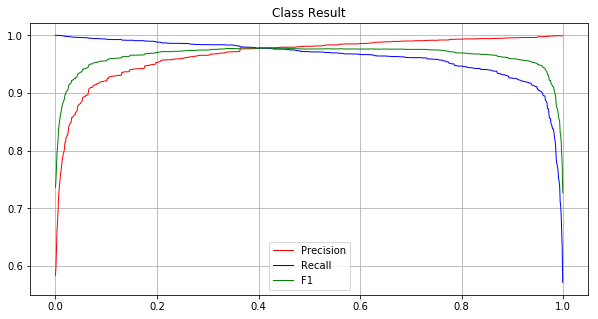

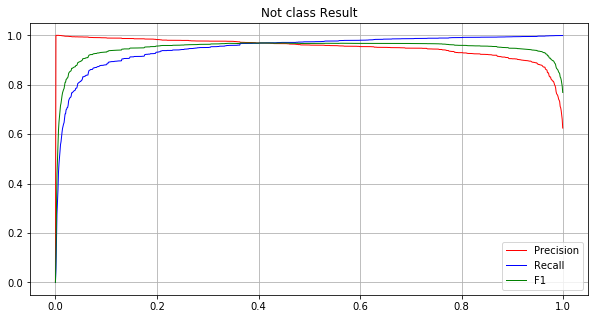

In [ ]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.001, trace=1)

In [ ]:
TEST_DATA_FILE  = 'kaggle/kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

threshold = 0.368

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction = 1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

00:40:07 INFO:Complete items 00000
